## Graph Neural Network Property Predictor


## Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import pandas as pd
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, global_mean_pool
from tabulate import tabulate
import itertools
import networkx as nx  # Added missing import
import numpy as np

# Add project root to path
import os
import sys
notebook_dir = os.path.dirname(os.path.abspath('__file__'))
project_root = os.path.dirname(notebook_dir)
sys.path.append(project_root)

# Working on segmenting from monolithic structure as this file is getting too lengthy
from model import GNN
from utils.config import MODEL_CONFIG, TRAINING_CONFIG, ANALYSIS_CONFIG, FEATURE_NAMES
from utils.visualization import VisualizationManager

c:\Users\Will\miniforge3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Graph Generation Functions

In [2]:
def find_connected_subgraph(G, size=4):
    """Find a connected subgraph of specified size"""
    for component in nx.connected_components(G):
        subgraph = G.subgraph(component)
        if len(subgraph) >= size:
            start_node = np.random.choice(list(subgraph.nodes()))
            nodes = list(nx.bfs_tree(subgraph, start_node))[:size]
            return nodes
    return None

def generate_graph(num_nodes=100, edge_prob=0.05):
    """Generate a random graph ensuring it has at least one connected component of size 4"""
    while True:
        G = nx.erdos_renyi_graph(n=num_nodes, p=edge_prob)
        connected_nodes = find_connected_subgraph(G, size=4)
        if connected_nodes is not None:
            return G, connected_nodes

## Feature Computation Functions

In [3]:
def compute_features(G, nodes):
    if nodes is None or len(nodes) != 4:
        raise ValueError("Must provide exactly 4 nodes for feature computation")
    
    features = []
    n_nodes = len(G)

    def normalize_metric_dict(metric_dict, min_val=0.1):
        """Normalize dictionary values to [min_val, 1] range."""
        values = np.array(list(metric_dict.values()))
        min_metric = np.min(values)
        max_metric = np.max(values)
        
        if max_metric == min_metric:
            return {k: min_val for k in metric_dict.keys()}
            
        normalized = {
            k: min_val + (v - min_metric) * (1 - min_val) / (max_metric - min_metric)
            for k, v in metric_dict.items()
        }
        return normalized
    
    # Pre-compute and normalize all centrality metrics
    try:
        # Compute and normalize basic centrality metrics
        betweenness = normalize_metric_dict(nx.betweenness_centrality(G))
        closeness = normalize_metric_dict(nx.closeness_centrality(G))
        pagerank = normalize_metric_dict(nx.pagerank(G))
        core_numbers = normalize_metric_dict(nx.core_number(G))
        degrees = normalize_metric_dict(dict(G.degree()))
        
        # Enhanced clustering computation and normalization
        clustering = nx.clustering(G)
        clustering = normalize_metric_dict(clustering)
        
        # Handle eigenvector centrality for largest component
        largest_cc = max(nx.connected_components(G), key=len)
        subgraph = G.subgraph(largest_cc)
        eigenvector = nx.eigenvector_centrality_numpy(subgraph)
        min_eigen = min(eigenvector.values())
        eigenvector.update({n: min_eigen for n in G.nodes() if n not in eigenvector})
        eigenvector = normalize_metric_dict(eigenvector)
        
    except Exception as e:
        print(f"Error computing centrality metrics: {str(e)}")
        raise
    
    # Process each node
    for node in nodes:
        # Calculate neighbor-based metrics
        neighbors = list(G.neighbors(node))
        avg_neighbor_degree = (
            np.mean([degrees[n] for n in neighbors]) 
            if neighbors else 0.1  # Use minimum value if no neighbors
        )
        
        # Compile node features
        node_features = [
            degrees[node],
            clustering[node],
            avg_neighbor_degree,
            betweenness[node],
            closeness[node],
            pagerank[node],
            core_numbers[node],
            compute_local_efficiency(G, node),
            eigenvector[node]
        ]
        features.extend(node_features)
    
    # Compute and normalize global features
    global_features = [
        nx.density(G),
        nx.average_clustering(G),
        nx.average_shortest_path_length(G) / n_nodes if nx.is_connected(G) else 0.1,
        nx.degree_assortativity_coefficient(G),
        nx.transitivity(G),
        len(list(nx.connected_components(G))) / n_nodes,
        max(degrees.values()),
        min(degrees.values()),
        np.mean(list(degrees.values())),
        nx.global_efficiency(G)
    ]
    
    # Normalize global features
    global_features = normalize_metric_dict(
        {str(i): v for i, v in enumerate(global_features)}
    ).values()
    
    features.extend(global_features)
    return torch.tensor(features, dtype=torch.float32)

def prepare_node_features(G):
    """Prepare node features including removal flag"""
    num_nodes = G.number_of_nodes()
    # Basic features for each node (5 base features + 1 removal flag)
    features = torch.zeros(num_nodes, 6)
    
    for i in range(num_nodes):
        features[i] = torch.tensor([
            G.degree[i],
            nx.clustering(G, i),
            np.mean([G.degree[n] for n in G.neighbors(i)]) if list(G.neighbors(i)) else 0,
            list(nx.betweenness_centrality(G).values())[i],
            list(nx.closeness_centrality(G).values())[i],
            0  # Removal flag, will be set later
        ])
    return features

def prepare_edge_index(G):
    """Convert NetworkX graph edges to PyG edge index"""
    return torch.tensor([[e[0], e[1]] for e in G.edges()]).t().contiguous()

def calculate_feature_accuracy(predicted, target, threshold=0.1):
    """
    Calculate accuracy for each feature based on relative error.
    
    Args:
        predicted (torch.Tensor): Predicted features
        target (torch.Tensor): Target features
        threshold (float): Threshold for considering a prediction accurate
        
    Returns:
        torch.Tensor: Binary accuracy for each feature
    """
    # Avoid division by zero
    epsilon = 1e-8
    
    # Calculate relative error
    relative_error = torch.abs(predicted - target) / (torch.abs(target) + epsilon)
    
    # Convert to binary accuracy (1 if error is below threshold, 0 otherwise)
    accuracy = (relative_error < threshold).float()
    
    return accuracy

def compute_local_efficiency(G, node):
    """
    Compute local efficiency for a node in the graph
    """
    neighbors = list(G.neighbors(node))
    if len(neighbors) < 2:
        return 0.0
    
    # Create subgraph of node's neighbors
    subgraph = G.subgraph(neighbors)
    if len(subgraph) < 2:
        return 0.0
    
    try:
        # Calculate average shortest path length in subgraph
        avg_path_length = nx.average_shortest_path_length(subgraph)
        return 1.0 / avg_path_length if avg_path_length > 0 else 0.0
    except nx.NetworkXError:
        # Handle disconnected graphs
        return 0.0

## Data Processing Functions

In [4]:
def process_graph_data(G, selected_nodes, target_idx):
    """Process graph data with proper node-wise feature variation"""
    # Compute features
    all_features = compute_features(G, selected_nodes)
    
    if not isinstance(all_features, torch.Tensor):
        all_features = torch.tensor(all_features, dtype=torch.float)
    
    num_nodes = len(G)
    num_features = len(FEATURE_NAMES) - 1
    x = torch.zeros((num_nodes, num_features))
    
    # Add node-wise variation to features
    current_idx = 0
    for i in range(len(FEATURE_NAMES)):
        if i != target_idx:
            base_value = all_features[i].clone()
            # Create node-specific variations
            variations = torch.randn(num_nodes) * 0.1  # 10% variation
            node_values = base_value + variations
            # Ensure values stay in reasonable range
            node_values = torch.clamp(node_values, min=0.0, max=1.0)
            x[:, current_idx] = node_values
            current_idx += 1
    
    # Prepare edge index
    edge_list = list(G.edges())
    edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous()
    
    # Create data object
    data = Data(
        x=x,
        edge_index=edge_index,
        original_features=all_features
    )
    
    print("\nData Processing Debug:")
    print(f"Number of nodes: {num_nodes}")
    print(f"Number of features: {num_features}")
    print(f"Feature tensor shape: {x.shape}")
    print(f"Edge index shape: {edge_index.shape}")
    print(f"Sample feature means: {x.mean(dim=0)[:5]}")
    print(f"Sample feature stds: {x.std(dim=0)[:5]}")
    
    return data

def compute_features(G, nodes):
    if nodes is None or len(nodes) != 4:
        raise ValueError("Must provide exactly 4 nodes for feature computation")
    
    features = []
    n_nodes = len(G)

    def normalize_metric_dict(metric_dict, min_val=0.1):
        """Normalize dictionary values to [min_val, 1] range."""
        values = np.array(list(metric_dict.values()))
        min_metric = np.min(values)
        max_metric = np.max(values)
        
        if max_metric == min_metric:
            return {k: min_val for k in metric_dict.keys()}
            
        normalized = {
            k: min_val + (v - min_metric) * (1 - min_val) / (max_metric - min_metric)
            for k, v in metric_dict.items()
        }
        return normalized
    
    # Pre-compute and normalize all centrality metrics
    try:
        # Compute and normalize basic centrality metrics
        betweenness = normalize_metric_dict(nx.betweenness_centrality(G))
        closeness = normalize_metric_dict(nx.closeness_centrality(G))
        pagerank = normalize_metric_dict(nx.pagerank(G))
        core_numbers = normalize_metric_dict(nx.core_number(G))
        degrees = normalize_metric_dict(dict(G.degree()))
        
        # Custering computation and normalization
        clustering = nx.clustering(G)
        clustering = normalize_metric_dict(clustering)
        
        # Handle eigenvector centrality for largest component
        largest_cc = max(nx.connected_components(G), key=len)
        subgraph = G.subgraph(largest_cc)
        eigenvector = nx.eigenvector_centrality_numpy(subgraph)
        min_eigen = min(eigenvector.values())
        eigenvector.update({n: min_eigen for n in G.nodes() if n not in eigenvector})
        eigenvector = normalize_metric_dict(eigenvector)
        
    except Exception as e:
        print(f"Error computing centrality metrics: {str(e)}")
        raise
    
    # Process each node
    for node in nodes:
        # Calculate neighbor-based metrics
        neighbors = list(G.neighbors(node))
        avg_neighbor_degree = (
            np.mean([degrees[n] for n in neighbors]) 
            if neighbors else 0.1  # Use minimum value if no neighbors
        )
        
        # Compile node features
        node_features = [
            degrees[node],
            clustering[node],
            avg_neighbor_degree,
            betweenness[node],
            closeness[node],
            pagerank[node],
            core_numbers[node],
            compute_local_efficiency(G, node),
            eigenvector[node]
        ]
        features.extend(node_features)
    
    # Compute and normalize global features
    global_features = [
        nx.density(G),
        nx.average_clustering(G),
        nx.average_shortest_path_length(G) / n_nodes if nx.is_connected(G) else 0.1,
        nx.degree_assortativity_coefficient(G),
        nx.transitivity(G),
        len(list(nx.connected_components(G))) / n_nodes,
        max(degrees.values()),
        min(degrees.values()),
        np.mean(list(degrees.values())),
        nx.global_efficiency(G)
    ]
    
    # Normalize global features
    global_features = normalize_metric_dict(
        {str(i): v for i, v in enumerate(global_features)}
    ).values()
    
    features.extend(global_features)
    return torch.tensor(features, dtype=torch.float32)

def find_connected_subgraph(G, size=4):
    """Find a connected subgraph of specified size"""
    for component in nx.connected_components(G):
        subgraph = G.subgraph(component)
        if len(subgraph) >= size:
            start_node = np.random.choice(list(subgraph.nodes()))
            nodes = list(nx.bfs_tree(subgraph, start_node))[:size]
            return nodes
    return None



## Execution


Data Processing Debug:
Number of nodes: 100
Number of features: 45
Feature tensor shape: torch.Size([100, 45])
Edge index shape: torch.Size([2, 251])
Sample feature means: tensor([0.6944, 0.1695, 0.4209, 0.8360, 0.7755])
Sample feature stds: tensor([0.1016, 0.1096, 0.1034, 0.0918, 0.0890])
Epoch   0: Train Loss = 0.6222, Validation Loss = 0.2860
Epoch   5: Train Loss = 0.4643, Validation Loss = 0.0512
Epoch  10: Train Loss = 0.3015, Validation Loss = 0.0399
Epoch  15: Train Loss = 0.2757, Validation Loss = 0.0429
Epoch  20: Train Loss = 0.2307, Validation Loss = 0.0402
Epoch  25: Train Loss = 0.2280, Validation Loss = 0.0468
Epoch  30: Train Loss = 0.2366, Validation Loss = 0.0579


c:\Users\Will\miniforge3\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([100, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch  35: Train Loss = 0.1854, Validation Loss = 0.0464
Epoch  40: Train Loss = 0.1945, Validation Loss = 0.0388
Epoch  45: Train Loss = 0.1335, Validation Loss = 0.0357
Epoch  50: Train Loss = 0.1910, Validation Loss = 0.0330
Epoch  55: Train Loss = 0.1437, Validation Loss = 0.0321
Epoch  60: Train Loss = 0.1534, Validation Loss = 0.0337
Epoch  65: Train Loss = 0.1620, Validation Loss = 0.0375
Epoch  70: Train Loss = 0.1523, Validation Loss = 0.0412
Epoch  75: Train Loss = 0.1386, Validation Loss = 0.0386
Epoch  80: Train Loss = 0.1267, Validation Loss = 0.0295
Epoch  85: Train Loss = 0.1593, Validation Loss = 0.0215
Epoch  90: Train Loss = 0.0962, Validation Loss = 0.0180
Epoch  95: Train Loss = 0.1354, Validation Loss = 0.0175


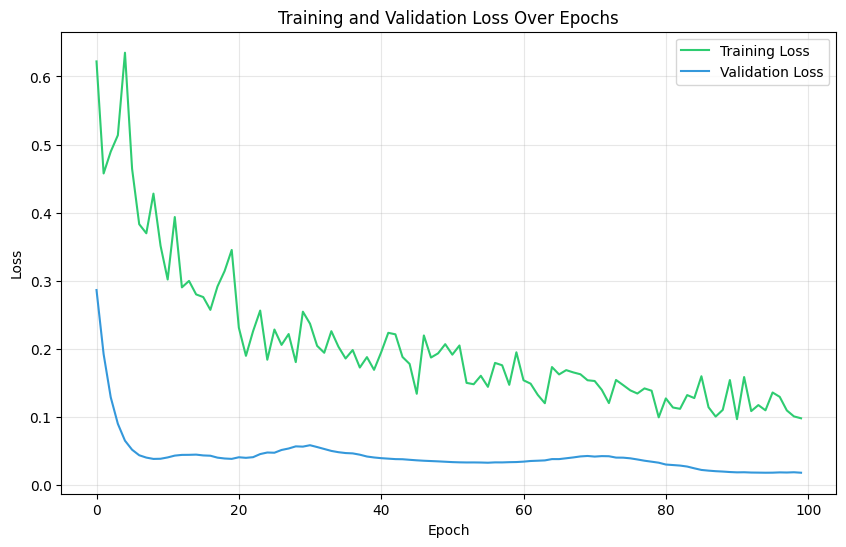


Final Validation Metrics:
val_loss: 0.0174
mae: 0.1066
r2_score: -inf


In [5]:
# Generate graph and prepare data
G, selected_nodes = generate_graph(num_nodes=100, edge_prob=0.05)

# Select target feature for analysis  
target_feature = "Node1_Betweenness"
target_idx = FEATURE_NAMES.index(target_feature)

# Process graph data
data = process_graph_data(G, selected_nodes, target_idx)

# Initialize model and trainer
model = GNN(node_feature_dim=len(FEATURE_NAMES)-1)

# Train model
losses, trained_model = model.train_model(model, data=data, target_idx=target_idx)

# Plot training progress
vis = VisualizationManager()
vis.plot_training_progress(
    train_losses=[loss['train_loss'] for loss in losses],
    val_losses=[loss['val_loss'] for loss in losses],  # Changed from test_loss to val_loss
    title="Training and Validation Loss Over Epochs"     # Updated title
)

# Get final validation metrics using the evaluate method
val_metrics = trained_model.evaluate(data, target_idx)   # Changed variable name for clarity
print("\nFinal Validation Metrics:")                     # Updated print message
for metric, value in val_metrics.items():
    print(f"{metric}: {value:.4f}")

# Print final test metrics
# test_metrics = trainer.test(trained_model, data, target_idx)
# print("\nFinal Test Metrics:")
# for metric, value in test_metrics.items():
#     print(f"{metric}: {value:.4f}")